# Diffusion Model for Gaussian Mix

In [14]:
import torch 
import numpy as np
import tensorboard as tb 
import matplotlib.pyplot as plt
import scipy.stats as st
import random
from torch import optim, nn, utils, Tensor

import plotly.express as px
import pandas as pd
import torch
import lightning as L

from pytorch_lightning.loggers import TensorBoardLogger



In [15]:
# Setting a seed and setting the device

seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print("CUDA available — deterministic settings applied.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available — seed set, but determinism not guaranteed.")
else:
    device = torch.device("cpu")
    print("CPU-only — seed set.")

print("Device = ", device)

def set_seed(seed_value=42):
    np.random.seed(seed_value)
    random.seed(seed_value)
    torch.manual_seed(seed_value)


MPS is available — seed set, but determinism not guaranteed.
Device =  mps


## Defining the distribution to be simulated and the dataset 

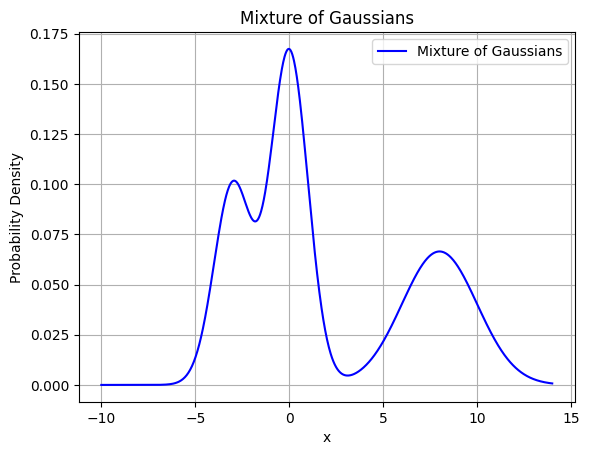

In [16]:
means = np.array([-3, 0, 8])         
stds = np.array([1, 1, 2])           
weights = np.array([1/4, 5/12, 1/3]) 

gaussian1 = st.norm(loc=means[0], scale=stds[0])
gaussian2 = st.norm(loc=means[1], scale=stds[1])
gaussian3 = st.norm(loc=means[2], scale=stds[2])


x = np.linspace(-10, 14, 1000)
pdf1 = gaussian1.pdf(x)
pdf2 = gaussian2.pdf(x)
pdf3 = gaussian3.pdf(x)

mixed_pdf = weights[0] * pdf1 + weights[1] * pdf2 + weights[2] * pdf3


plt.plot(x, mixed_pdf, label="Mixture of Gaussians", color='blue')

plt.title("Mixture of Gaussians")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()




In [17]:

def dataset_gen(weights: np.ndarray, means: np.ndarray = np.array([0, 0, 0]), stds: np.ndarray = np.array([1, 1, 1]), device: torch.device = torch.device('cpu'), size: int = 1000, seed: int = None) -> torch.Tensor:
    """
    We generate a gaussian mixture using weights, means and std. 
    The result is a sample of the gaussian mix.
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    chosen_dists = np.random.choice(len(weights), size=size, p=weights)
    samples = np.random.normal(means[chosen_dists], stds[chosen_dists])
    return torch.tensor(samples, dtype=torch.float32, device=device).unsqueeze(1)


n = 10000
x_0 = dataset_gen(weights = weights, means = means, stds = stds, device = device, size = n, seed = seed_value )


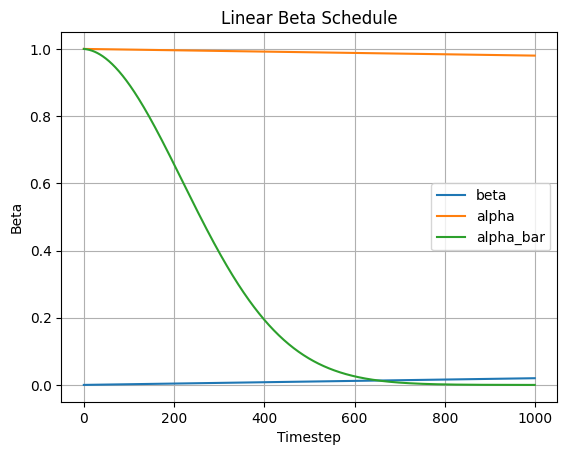

In [18]:
# We define the beta scheduler

def linear_beta_scheduler(timesteps: int, start: float = 1e-4, end: float = 0.02):
    return torch.linspace(start, end, timesteps, device = device)

timesteps = 1000

beta =  linear_beta_scheduler(timesteps)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)

plt.plot(beta.cpu().numpy(), label = "beta")
plt.plot(alpha.cpu().numpy(), label = "alpha")
plt.plot(alpha_bar.cpu().numpy(), label = "alpha_bar")
plt.title("Linear Beta Schedule")
plt.xlabel("Timestep")
plt.ylabel("Beta")
plt.legend()
plt.grid(True)
plt.show()



## Defining the noising function and visualizing the noising process

In [19]:
def noising(t_index : torch.Tensor, x_0: torch.Tensor, alpha_bar: torch.Tensor, seed : int = None, noise : torch.tensor = None) -> torch.Tensor:
    """ 
    This function defines the noising process from a batch tensor of x_0
    x_0 is supposed to be of size batch_size x x_size
    t is supposed to be of size batch_size
    Attention to t_index, tensor are indexed with a shift of -1 in comparaison to timesteps. 
    If we pass the indexes we should just perform alpha_bar[t_index], if we pass time steps we should do alpha_bar[t_index -1]
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    if noise is None:
        noise = torch.randn_like(x_0, device = x_0.device)  
    alpha_bar_t = alpha_bar[t_index]
    for _ in range(x_0.dim() - 1):
        alpha_bar_t = alpha_bar_t.unsqueeze(-1)
        

    return  torch.sqrt(alpha_bar_t)*x_0 + noise * torch.sqrt(1 - alpha_bar_t) 


In [20]:
data = []

for t in range(0, timesteps, 50): 
    
    t_index = torch.full((x_0.shape[0],), t, device=device)
    noised = noising(t_index, x_0, alpha_bar, seed=42)
    for val in noised.flatten().cpu().numpy():
        data.append({'value': val, 'timestep': t})

df = pd.DataFrame(data)

fig = px.histogram(df, x='value', animation_frame='timestep', nbins = 90, histnorm='probability density', range_x=[-10, 15])

fig.update_layout(
    title=f"Empirical distribution of the dataset during noising",
    xaxis_title="Value",
    yaxis_title="Density",
    showlegend=False,
    yaxis=dict(range=[0, 0.4]),
    xaxis=dict(range=[-7, 15])

)

fig.show()




## Introducing the Score Estimator

In [21]:
# Definition of the model
"""
class ScoreEstimator(L.LightningModule):
    
    def __init__(self, time_dim, x_dim, hidden_dim):
        super().__init__()
        self.x_dim = x_dim
        self.time_dim = time_dim
        self.layer1 = nn.Linear(x_dim + time_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.layer2 = nn.Linear(hidden_dim, x_dim)
        
        
    def forward(self,x,t) : 
        x_t = torch.cat([x,t], dim=1)
        y = self.layer1(x_t)
        y = self.activation(y)
        return self.layer2(y)
    
    def training_step(self, batch):
        noise = torch.randn_like(batch, device = batch.device) 
        t = torch.randint(0, timesteps, size=(batch.shape[0],), device=batch.device)   
        noised = noising(t_index = t , x_0 = batch, alpha_bar = alpha_bar, seed  = 42, noise = noise) 
        loss = nn.functional.mse_loss(noise, self.forward(noised,t.unsqueeze(1)))
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

score = ScoreEstimator(1,1,32)
"""


"\nclass ScoreEstimator(L.LightningModule):\n    \n    def __init__(self, time_dim, x_dim, hidden_dim):\n        super().__init__()\n        self.x_dim = x_dim\n        self.time_dim = time_dim\n        self.layer1 = nn.Linear(x_dim + time_dim, hidden_dim)\n        self.activation = nn.ReLU()\n        self.layer2 = nn.Linear(hidden_dim, x_dim)\n        \n        \n    def forward(self,x,t) : \n        x_t = torch.cat([x,t], dim=1)\n        y = self.layer1(x_t)\n        y = self.activation(y)\n        return self.layer2(y)\n    \n    def training_step(self, batch):\n        noise = torch.randn_like(batch, device = batch.device) \n        t = torch.randint(0, timesteps, size=(batch.shape[0],), device=batch.device)   \n        noised = noising(t_index = t , x_0 = batch, alpha_bar = alpha_bar, seed  = 42, noise = noise) \n        loss = nn.functional.mse_loss(noise, self.forward(noised,t.unsqueeze(1)))\n        self.log('train_loss', loss, prog_bar=True)\n        return loss\n\n    def con

In [22]:
# Training the model
"""

trainer = L.Trainer(max_epochs=1)

trainer.fit(model=score, train_dataloaders=train_loader)
"""

'\n\ntrainer = L.Trainer(max_epochs=1)\n\ntrainer.fit(model=score, train_dataloaders=train_loader)\n'

In [ ]:
class NoiseEstimator(nn.Module):
    
    def __init__(self, time_dim, x_dim, hidden_dim, timesteps):
        super().__init__()
        self.x_dim = x_dim
        self.time_dim = time_dim
        self.time_embedding = nn.Embedding(timesteps, time_dim)
        
        self.layer1 = nn.Linear(x_dim + time_dim, hidden_dim)
        self.activation = nn.Sigmoid()
        self.timesteps = timesteps
        self.layer2 = nn.Linear(hidden_dim, x_dim)
        
        
    def forward(self, x, t): 
        t = self.time_embedding(t)
        x_t = torch.cat([x, t], dim=1)
        y = self.layer1(x_t)
        y = self.activation(y)
        
        
        return self.layer2(y)
    
score = ScoreEstimator(time_dim = 3, x_dim=1, hidden_dim = 64, timesteps = timesteps)
train_loader = utils.data.DataLoader(x_0, batch_size=128)



In [ ]:
def train(model, dataloader, timesteps, alpha_bar, noising, epochs=500, lr=1e-4, device='cuda'):
    
    """
    This function simply implements the training of the noiser model
    
    Training using the instructions given by arXiv:2006.11239v2
    
    """
    model = model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in dataloader:
            batch = batch.to(device)
            noise = torch.randn_like(batch)
            t = torch.randint(0, timesteps, size=(batch.shape[0],), device=batch.device)
            noised = noising(t_index=t, x_0=batch, alpha_bar=alpha_bar, seed=42, noise=noise)
            pred_noise = model(noised, t)
            
            loss = nn.functional.mse_loss(pred_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total_loss / len(dataloader)}")
    
    model.eval()

train(score, train_loader, timesteps, alpha_bar, noising, lr = 1e-4, device = device )

Epoch 1: Loss = 0.9075777138335795
Epoch 2: Loss = 0.8767263466798807
Epoch 3: Loss = 0.8552576394020757
Epoch 4: Loss = 0.8398164058033424
Epoch 5: Loss = 0.8284677085997183
Epoch 6: Loss = 0.8196748834622057
Epoch 7: Loss = 0.8123017972028708
Epoch 8: Loss = 0.8055842896051044
Epoch 9: Loss = 0.7990558668027951
Epoch 10: Loss = 0.7924586708032633
Epoch 11: Loss = 0.7856653242171565
Epoch 12: Loss = 0.7786229215090787
Epoch 13: Loss = 0.7713178177423115
Epoch 14: Loss = 0.7637559839441806
Epoch 15: Loss = 0.7559527845322331
Epoch 16: Loss = 0.7479281123680405
Epoch 17: Loss = 0.7397038310388976
Epoch 18: Loss = 0.7313025299506851
Epoch 19: Loss = 0.7227468196349808
Epoch 20: Loss = 0.7140588624567925
Epoch 21: Loss = 0.705260053465638
Epoch 22: Loss = 0.6963710037967826
Epoch 23: Loss = 0.6874114041086994
Epoch 24: Loss = 0.678400072115886
Epoch 25: Loss = 0.6693548469603816
Epoch 26: Loss = 0.6602925394154802
Epoch 27: Loss = 0.6512288058860393
Epoch 28: Loss = 0.6421780450434624
Epo

## Generation

In [ ]:
def generate(size: int = 100, seed: int = None, x_t: torch.Tensor = None, score: nn.Module = None ) -> list:  
    
    """
    Generation of the sample using the instructions given by arXiv:2006.11239v2
    """
    
    x = []
    
    
    
    alpha_bar_minus = nn.functional.pad(
            alpha_bar[:-1], (1, 0), value=1.0)
        
    sigma = torch.sqrt(beta * (1.0 - alpha_bar_minus) / (1.0 - alpha_bar))

    if seed is not None:
        torch.manual_seed(seed)

    if x_t is None: 
        x_t = torch.randn(size, 1, device=device)

    x.append(x_t.clone().detach()) 

    score.eval()

    with torch.no_grad():
        for t in reversed(range(timesteps)): 
            t_index = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)

            score_t = score(x_t, t_index)

            z = torch.randn_like(x_t) if t > 0 else 0.0

            coef = (1 - alpha[t]) / torch.sqrt(1 - alpha_bar[t])
            
            x_t = (
                (1 / torch.sqrt(alpha[t]))
                * (x_t - ((1 - alpha[t]) / torch.sqrt(1 - alpha_bar[t])) * score_t)
                + sigma[t] * z
            )
            x.append(x_t.clone().detach())
    print(sigma)
    return x




tensor([0.0000, 0.0074, 0.0092, 0.0105, 0.0116, 0.0125, 0.0133, 0.0140, 0.0148,
        0.0154, 0.0161, 0.0167, 0.0173, 0.0179, 0.0184, 0.0189, 0.0195, 0.0200,
        0.0205, 0.0210, 0.0214, 0.0219, 0.0223, 0.0228, 0.0232, 0.0236, 0.0241,
        0.0245, 0.0249, 0.0253, 0.0257, 0.0260, 0.0264, 0.0268, 0.0272, 0.0275,
        0.0279, 0.0282, 0.0286, 0.0289, 0.0293, 0.0296, 0.0300, 0.0303, 0.0306,
        0.0309, 0.0313, 0.0316, 0.0319, 0.0322, 0.0325, 0.0328, 0.0331, 0.0334,
        0.0337, 0.0340, 0.0343, 0.0346, 0.0349, 0.0352, 0.0354, 0.0357, 0.0360,
        0.0363, 0.0366, 0.0368, 0.0371, 0.0374, 0.0376, 0.0379, 0.0382, 0.0384,
        0.0387, 0.0389, 0.0392, 0.0394, 0.0397, 0.0399, 0.0402, 0.0404, 0.0407,
        0.0409, 0.0412, 0.0414, 0.0417, 0.0419, 0.0421, 0.0424, 0.0426, 0.0428,
        0.0431, 0.0433, 0.0435, 0.0438, 0.0440, 0.0442, 0.0444, 0.0447, 0.0449,
        0.0451, 0.0453, 0.0455, 0.0458, 0.0460, 0.0462, 0.0464, 0.0466, 0.0468,
        0.0471, 0.0473, 0.0475, 0.0477, 

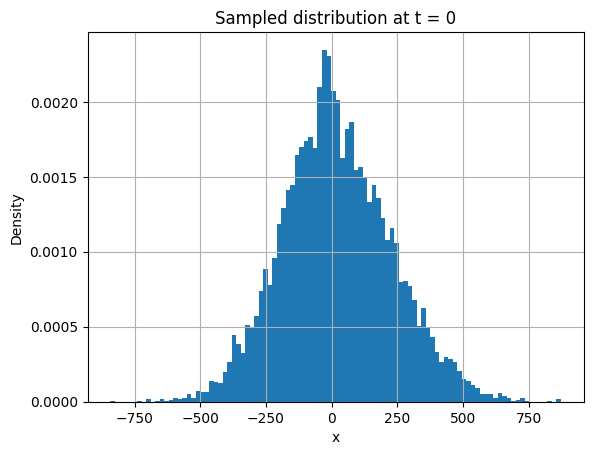

In [41]:
x = generate(size =  10000, seed = 42, score = score)

x_0 = x[-1]


plt.hist(x_0.squeeze().cpu().numpy(), bins=100, density=True)
plt.title("Sampled distribution at t = 0")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.show()